<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2023notebooks/2023_0714stable_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
date: 2023_0706
source: https://huggingface.co/docs/diffusers/v0.7.0/en/api/pipelines/stable_diffusion#stable-diffusion-pipelines
---

# **Stable Diffusion** 🎨
<!-- *...using `🧨diffusers`* -->

Stable Diffusion は [CompVis](https://github.com/CompVis)，[Stability AI](https://stability.ai/)，[LAION](https://laion.ai/) の研究者とエンジニアによって作成されたテキストから画像への潜在拡散モデルです。
Stable Diffusion は [LAION-5B](https://laion.ai/blog/laion-5b/) データベースのサブセットから 512x512 画像で学習されました。
このモデルは，凍結された CLIP ViT-L/14 テキスト符号化器を使い，テキストプロンプトを条件としています。
860M の UNet と 123M のテキスト符号化器を持つこのモデルは，比較的軽量で，多くの民生用 GPU で実行可能です。
詳しくは [モデルカード](https://huggingface.co/CompVis/stable-diffusion) を見てください。
<!-- Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/).
It's trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database.
This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts.
With its 860M UNet and 123M text encoder, the model is relatively lightweight and can run on many consumer GPUs.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information. -->

<!-- This Colab notebook shows how to use Stable Diffusion with the 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). -->

<!-- Let's get started! -->

## 1. StableDiffusionPipeline の使い方 <!-- ## 1. How to use `StableDiffusionPipeline`-->

Stable diffusion がどのように機能するのか，理論的な側面に入る前に，
ちょっと使ってみましょう。
<!-- Before diving into the theoretical aspects of how Stable Diffusion functions,
let's try it out a bit 🤗. -->

ここでは，わずか数行のコードでテキストから画像への推論を実行する方法を紹介します！
<!-- In this section, we show how you can run text to image inference in just a few lines of code! -->

### セットアップ<!-- ### Setup-->


最初に，このノートブックを実行するために GPU ランタイムを使用していることを確認してください。
以下のコマンドが失敗する場合は，上の `Runtime` メニューから `Change runtime type` を選択してください。
<!--First, please make sure you are using a GPU runtime to run this notebook, so inference is much faster.
If the following command fails, use the `Runtime` menu above and select `Change runtime type`. -->

In [ ]:
!nvidia-smi

Fri Jul 14 03:39:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

次に、`diffusers` と `scipy`、`ftfy`、`transformers` をインストールします。
`accelerate` は読み込みを高速化するために使用します。
<!-- Next, you should install `diffusers` as well `scipy`, `ftfy` and `transformers`.
`accelerate` is used to achieve much faster loading. -->

In [1]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 99.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.4 MB/s eta 0:00:00


### Stable diffusion パイプライン <!-- ### Stable Diffusion Pipeline-->

StableDiffusion パイプラインはエンドツーエンドの推論パイプラインで，わずか数行のコードでテキストから画像を生成することができます。
<!--`StableDiffusionPipeline` is an end-to-end inference pipeline that you can use to generate images from text with just a few lines of code. -->

まず，モデルの全要素の事前学習された重みをロードします。
このノートブックでは，Stable Diffusion version 1.4 ([CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)) を使いますが，他にも試してみたいものがあるかもしれません：
* [runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5)
* [stabilityai/stable-diffusion-2-1-base](https://huggingface.co/stabilityai/stable-diffusion-2-1-base)
* [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1). このバージョンは 768x768 の解像度の画像を作成できますが，他のバージョンは 512x512 で動作します。

<!-- First, we load the pre-trained weights of all components of the model. In this notebook we use Stable Diffusion version 1.4 ([CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)), but there are other variants that you may want to try:
* [runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5)
* [stabilityai/stable-diffusion-2-1-base](https://huggingface.co/stabilityai/stable-diffusion-2-1-base)
* [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1). This version can produce images with a resolution of 768x768, while the others work at 512x512. -->

モデル ID  [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4) に加えて，特定の `revision` と `torch_dtype` を `from_pretrained` メソッドに渡しています。
<!-- In addition to the model id [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4), we're also passing a specific `revision` and `torch_dtype` to the `from_pretrained` method.-->

フリーの Google Colab がすべて Stable Diffusion を実行できるようにしたいので，半精度ブランチ [`fp16`](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16) から重み係数をロードし，`torch_dtype=torch.float16` を渡すことで`diffusers` に float16 の精度で重みを期待するように伝えています。
<!-- We want to ensure that every free Google Colab can run Stable Diffusion, hence we're loading the weights from the half-precision branch [`fp16`](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16) and also tell `diffusers` to expect the weights in float16 precision by passing `torch_dtype=torch.float16`. -->

可能な限り高い精度を確保したい場合は，メモリ使用量が増えることを覚悟で `torch_dtype=torch.float16` を削除してください。
<!--If you want to ensure the highest possible precision, please make sure to remove `torch_dtype=torch.float16` at the cost of a higher memory usage. -->

In [2]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)

safety_checker/pytorch_model.fp16.safetensors not found


Fetching 28 files:   0%|          | 0/28 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


次に，より高速な推論を行うために，パイプラインを GPU に移しましょう。
<!-- Next, let's move the pipeline to GPU to have faster inference. -->

In [3]:
pipe = pipe.to("cuda")

画像を生成する準備が整いました。
<!-- And we are ready to generate images: -->

  0%|          | 0/50 [00:00<?, ?it/s]

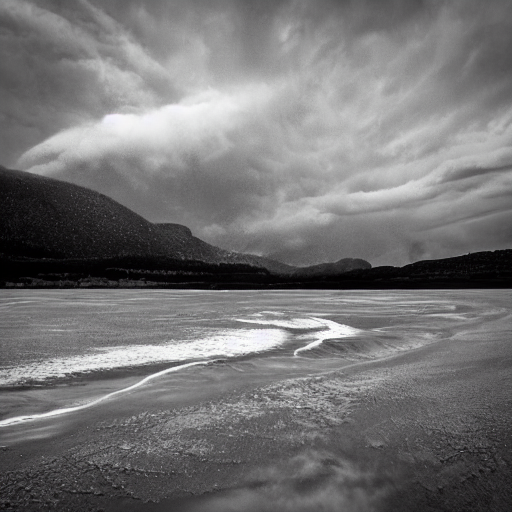

In [8]:
#prompt = "a photograph of an astronaut riding a horse"
prompt = "a photograph of a cute japanese girl wearing a bikini"
prompt = "quiet before storm"

image = pipe(prompt).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

# 画像を保存しるには以下を実行します。
#image.save(f"japanese_girl.png")

# グーグルコラボであれば，次のようにして直接表示することもできます。
image

上記のセルを複数回実行すると，毎回異なる画像が得られます。
もし決定論的な出力を望むなら，パイプラインにランダムなシードを渡すことができます。
同じシードを使うたびに，同じ画像結果が得られます。
<!-- Running the above cell multiple times will give you a different image every time. If you want deterministic output you can pass a random seed to the pipeline.
Every time you use the same seed you'll have the same image result. -->

  0%|          | 0/50 [00:00<?, ?it/s]

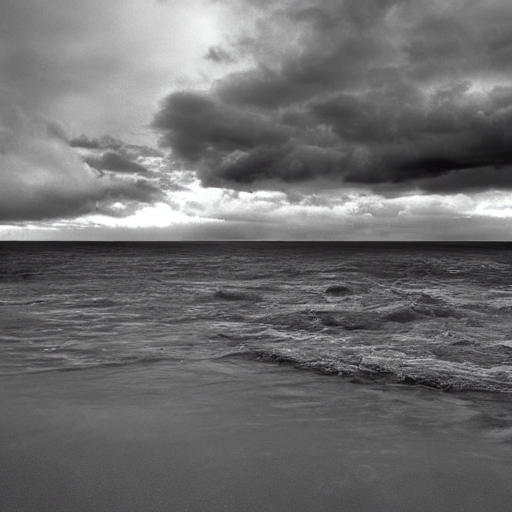

In [9]:
import torch

generator = torch.Generator("cuda").manual_seed(1024)
image = pipe(prompt, generator=generator).images[0]
image

`num_inference_steps` 引数で推論ステップ数を変更できる。
一般に，ステップ数が多いほど良い結果が得られます。
最新のモデルの 1 つである Stable Diffusion は，比較的少ないステップ数でうまく機能するので，デフォルトの`50`を使用することをお勧めします。
より速い結果を得たい場合は，より小さい数を使用することができます。
<!-- You can change the number of inference steps using the `num_inference_steps` argument.
In general, results are better the more steps you use.
Stable Diffusion, being one of the latest models, works great with a relatively small number of steps, so we recommend to use the default of `50`.
If you want faster results you can use a smaller number. -->

次のセルは，前と同じシードを使用していますが，ステップ数は少数です。
前の画像よりもはっきりせず、リアルでないことに注意してください：
<!-- The following cell uses the same seed as before, but with fewer steps. Note how some details, such as the horse's head or the helmet, are less defin realistic and less defined than in the previous image: -->

  0%|          | 0/15 [00:00<?, ?it/s]

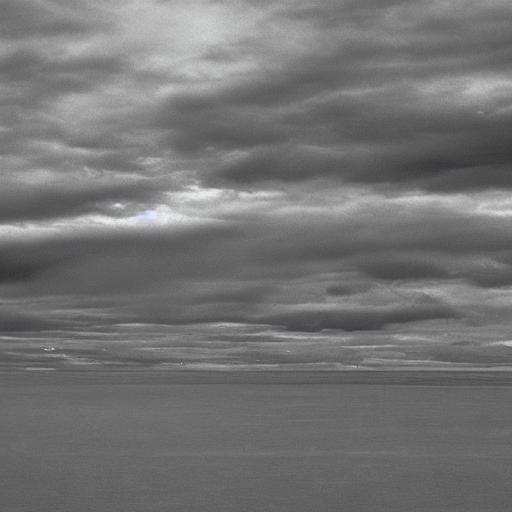

In [10]:
import torch

generator = torch.Generator("cuda").manual_seed(1024)
image = pipe(prompt, num_inference_steps=15, generator=generator).images[0]
image

パイプラインコールのもう 1 つのパラメータは `guidance_scale` です。
これは，条件信号 (この場合はテキスト)，および全体的なサンプルの品質への準拠を高める方法です。
簡単に言うと，分類器を使わないガイダンスは，よりプロンプトにマッチするように生成を強制します。
`7` や `8.5` のような数字は良い結果をもたらしますが，非常に大きな数字を使用した場合，画像は良く見えるかもしれませんが，多様性に欠けます。
<!-- The other parameter in the pipeline call is `guidance_scale`. It is a way to increase the adherence to the conditional signal which in this case is text as well as overall sample quality.
In simple terms classifier free guidance forces the generation to better match with the prompt. Numbers like `7` or `8.5` give good results, if you use a very large number the images might look good, but will be less diverse.-->

このパラメータの技術的な詳細については，次のノートの [最終節](https://colab.research.google.com/drive/1ALXuCM5iNnJDNW5vqBm5lCtUQtZJHN2f?authuser=1#scrollTo=UZp-ynZLrS-S) を参照してください。
<!-- You can learn about the technical details of this parameter in [the last section](https://colab.research.google.com/drive/1ALXuCM5iNnJDNW5vqBm5lCtUQtZJHN2f?authuser=1#scrollTo=UZp-ynZLrS-S) of this notebook. -->

同じプロンプトに対して複数の画像を生成するには，同じプロンプトを複数回繰り返したリストを使用します。
先ほど使った文字列の代わりに，このリストをパイプラインに送ります。
<!-- To generate multiple images for the same prompt, we simply use a list with the same prompt repeated several times. We'll send the list to the pipeline instead of the string we used before. -->

まずは画像のグリッドを表示するヘルパー関数を書いてみましょう。
以下のセルを実行するだけで，`image_grid` 関数が作成されます。
<!-- Let's first write a helper function to display a grid of images. Just run the following cell to create the `image_grid` function, or disclose the code if you are interested in how it's done. -->

In [11]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

これで，3 つのプロンプトのリストでパイプラインを実行すれば，グリッド画像を生成できます。
<!-- Now, we can generate a grid image once having run the pipeline with a list of 3 prompts. -->

  0%|          | 0/50 [00:00<?, ?it/s]

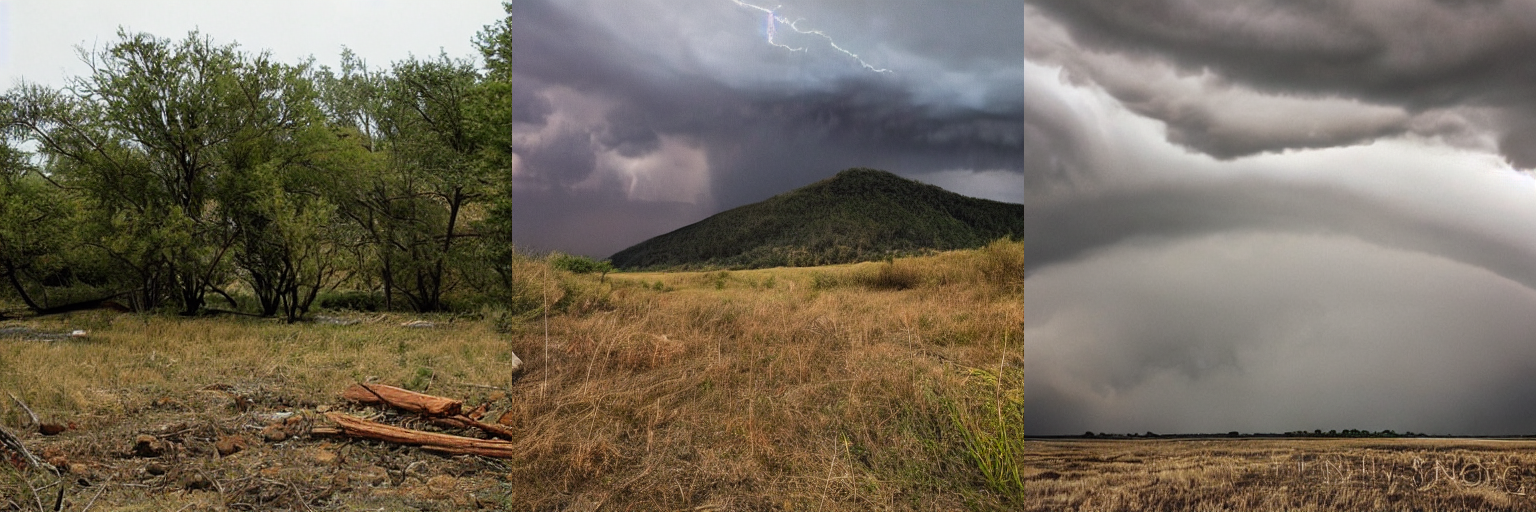

In [13]:
num_images = 3
prompt = ["a photograph of an astronaut riding a horse"] * num_images
prompt = ["a very cute japanese girl wearing bikini"] * num_images
prompt = ["quiet before a strom"] * num_images

images = pipe(prompt).images

grid = image_grid(images, rows=1, cols=3)
grid

And here's how to generate a grid of `n × m` images.

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

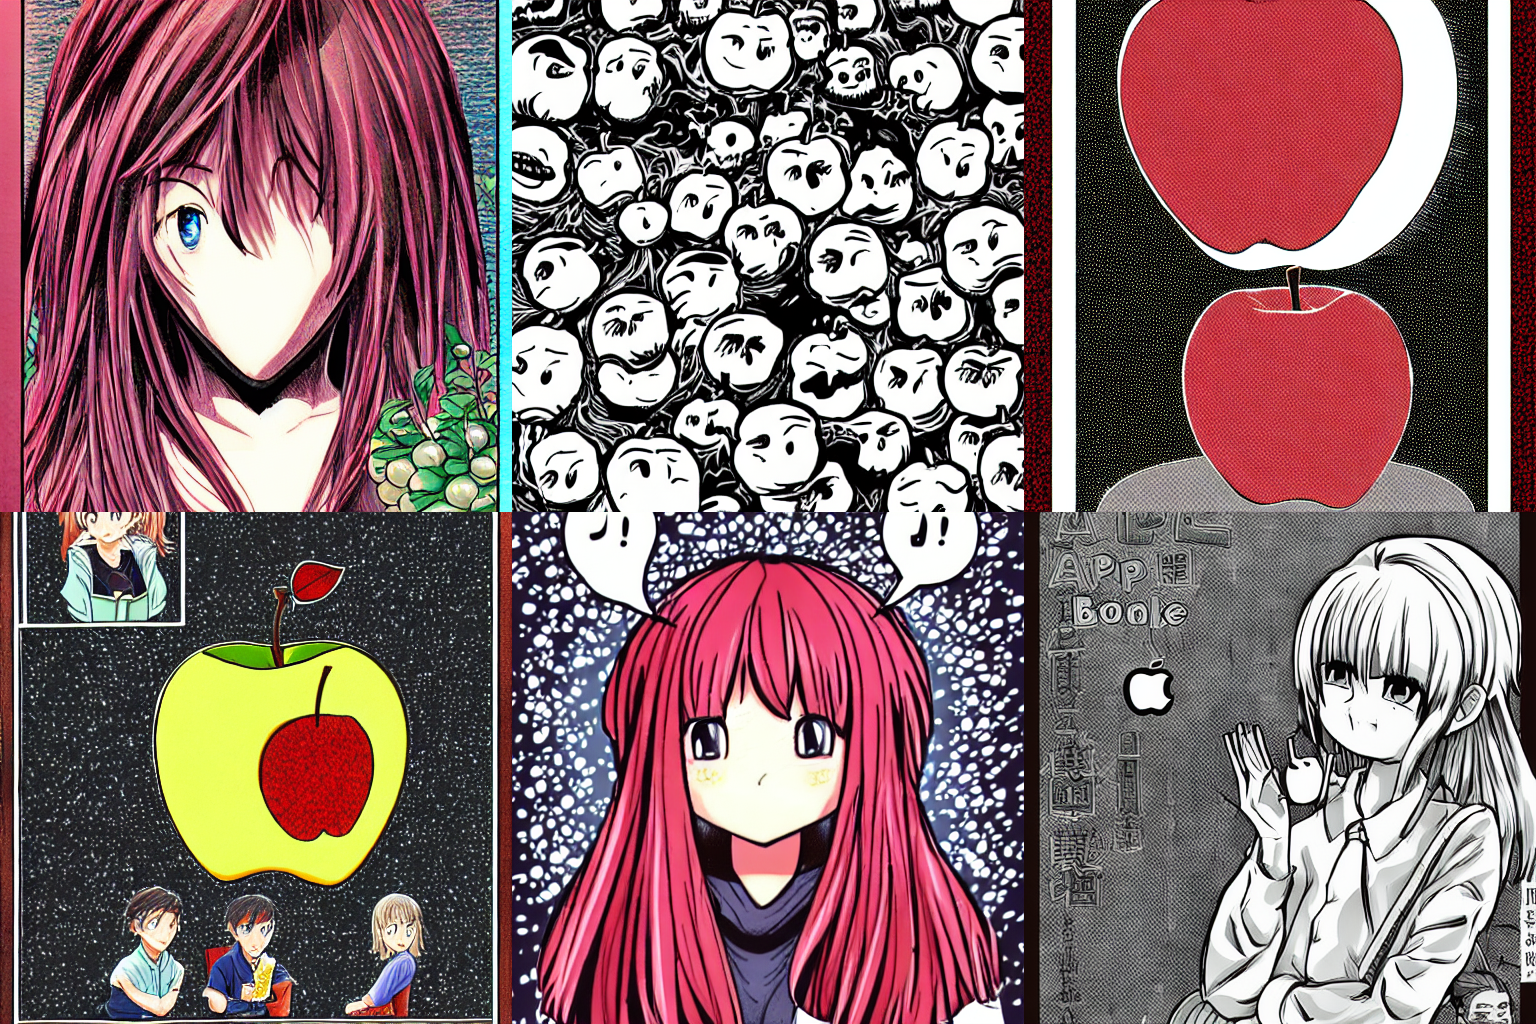

In [26]:
num_cols = 3
num_rows = 2

# prompt = ["calm before a heavy strom"] * num_images
prompt = ["a picture representing a phrase such as 'read between lines'"] * num_images
prompt = ["read between lines"] * num_images
prompt = ["metaphorical phrase such as 'read between lines'"] * num_images
prompt = ["kick the bucket"] * num_images
prompt = ["a manga of an apple without background"] * num_images
#prompt = ["a very cute japanese girl wearing kimono"] * num_images

all_images = []
for i in range(num_rows):
  images = pipe(prompt).images
  all_images.extend(images)

grid = image_grid(all_images, rows=num_rows, cols=num_cols)
grid

### 正方形以外の画像を生成する <!-- ### Generate non-square images-->

Stable Diffusion はデフォルトで `512 × 512` 画素の画像を生成します。
`height` と `width` 引数を使えば簡単にデフォルトを上書きできるので，縦長や横長の長方形の画像を作成することができます。
<!-- Stable Diffusion produces images of `512 × 512` pixels by default. But it's very easy to override the default using the `height` and `width` arguments, so you can create rectangular images in portrait or landscape ratios. -->

良い画像サイズを選ぶための推奨事項は以下の通りです：
- `height` と `width` がともに `8` の倍数であることを確認してください。
- 512を下回ると低画質になる可能性があります。
- 両方向で 512 を超えると、画像領域が繰り返されます（全体的な一貫性が失われます）。
- 正方形でない画像を作成する最善の方法は，1 つの次元で `512` を使用し，もう 1 つの次元でそれよりも大きな値を使用することです。

<!-- These are some recommendations to choose good image sizes:
- Make sure `height` and `width` are both multiples of `8`.
- Going below 512 might result in lower quality images.
- Going over 512 in both directions will repeat image areas (global coherence is lost).
- The best way to create non-square images is to use `512` in one dimension, and a value larger than that in the other one. -->

In [ ]:
prompt = "a photograph of very cute japanese girl"
#prompt = "a photograph of an astronaut riding a horse"

image = pipe(prompt, height=512, width=768).images[0]
image